# 第2章 利用用户行为数据

&emsp;&emsp;基于用户行为分析的推荐算法是个性化推荐系统的重要算法，这种类型的算法称为协同过滤算法。协同过滤是指用户可以齐心协力，通过不断地和网站互动，使自己的推荐列表能够不断过滤掉自己不感兴趣的物品，从而越来越满足自己的需求。

## 用户行为数据简介
&emsp;&emsp;用户行为数据在网站上最简单的存在形式就是日志。把多种原始日志按照用户行为汇总成会话日志（session log），其中每个会话表示一次用户行为和对应的服务，会话日志通常存储在分布式数据仓库中。  
&emsp;&emsp;用户行为在个性化推荐系统中一般分为两种：显性反馈行为和隐性反馈行为。显性反馈行为包括用户明确表示对物品喜好的行为。隐性反馈行为指那些不能明确反应用户喜好的行为（页面浏览行为）。 

&emsp;&emsp;| 显性反馈数据 | 隐性反馈数据 
--- | --- | ---
用户兴趣 | 明确 | 不明确
数量 | 较少 | 庞大
存储 | 数据库 | 分布式文件系统
实时读取 | 实时 | 有延迟
正负反馈 | 都有 | 只有正反馈

目前比较有代表性的数据集有下面几个：  
1. 无上下文信息的隐性反馈数据集：每一条行为记录仅仅包含用户ID和物品ID。
2. 无上下文信息的显性反馈数据集：每一条记录包含用户ID、物品ID和用户对物品的评分。
3. 有上下文信息的隐性反馈数据集：每一条记录包含用户ID、物品ID和用户对物品产生行为的时间戳。
4. 有上下文信息的显性反馈数据集：每一条记录包含用户ID、物品ID、用户对物品的评分和评分行为发生的时间戳。

## 用户行为分析

### 用户活跃度和物品流行度的分布

&emsp;&emsp;互联网上的很多数据分布都满足一种称为PowerLaw的分布，这种分布也称为长尾分布。$$f(x) = \alpha x^k$$  
&emsp;&emsp;用户行为数据也有上述规律。令$f_u(k)$为对$k$个物品产生过行为的用户数，令$f_i(k)$为$k$个用户产生过行为的物品数。那么，$f_u(k)$和$f_i(k)$都满足长尾分布。$$f_i(k)=\alpha_i k^{\beta_i} \\ f_u(k)=\alpha_u k^{\beta_u}$$

In [1]:
import os, sys
import pandas as pd
import numpy as np

PROJECT_ROOT = os.path.dirname(sys.path[0])

In [11]:
movieLen_df = pd.read_table(PROJECT_ROOT + '/src/data/ml-1m/ratings.dat', 
                            header=None, names=["user_id","movie_id","rating", "timestamp"], sep='::', engine='python')
movieLen_df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
sum_movie_rating = (
    movieLen_df[["user_id","movie_id"]].groupby(["movie_id"],as_index = False).count())
sum_movie_rating.rename(
                mapper = {"user_id" : "item_popularity"},
                axis = 1,
                inplace = True
)
sum_movie_rating = sum_movie_rating.groupby("item_popularity",as_index = False).count()
sum_movie_rating.rename(
                mapper = {"movie_id" : "counts"},
                axis = 1,
                inplace = True
)
sum_movie_rating["log_item_popularity"] = np.log10(sum_movie_rating["item_popularity"])
sum_movie_rating.head()

,item_popularity,counts,log_item_popularity
0,1,114,0.000000
1,2,89,0.301030
2,3,42,0.477121
3,4,45,0.602060
4,5,39,0.698970


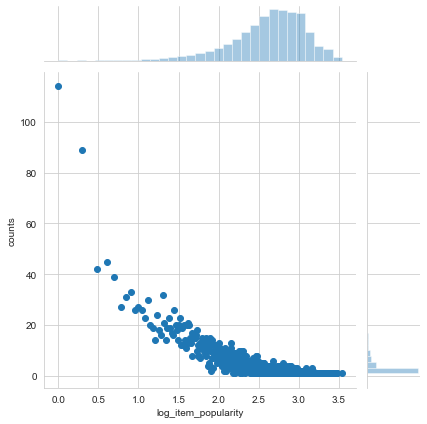

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

axe = sns.jointplot(x = "log_item_popularity",y = "counts",data = sum_movie_rating)

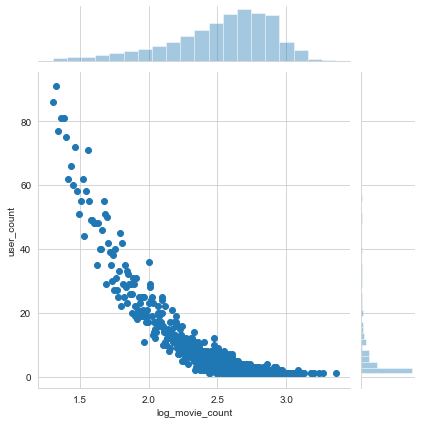

In [4]:
item_popularity = movieLen_df.groupby(["user_id"],as_index = False).count()
item_popularity.rename(mapper = {"movie_id" : "movie_count"},axis = 1,inplace = True)
item_popularity = item_popularity.groupby(["movie_count"],as_index = False).count()
item_popularity.rename(mapper = {"user_id" : "user_count"},axis = 1,inplace = True)
item_popularity["log_movie_count"] = np.log10(item_popularity.movie_count)

sns.set_style("whitegrid")

sns.jointplot(data = item_popularity,x = "log_movie_count",y = "user_count");

### 用户活跃度和物品流行度的关系
&emsp;&emsp;一般来说，不活跃的用户要么是新用户，要么是只来过网站一两次的老用户。新用户倾向于浏览热门的物品，而老用户会组件开始浏览冷门的物品。  
&emsp;&emsp;基于领域的方法主要包含下面两种算法：  
1. 基于用户的协同过滤算法：给用户推荐和他兴趣相似的其他用户喜欢的物品。
2. 基于物品的协同过滤算法：给用户推荐和他之前喜欢的物品相似的物品。

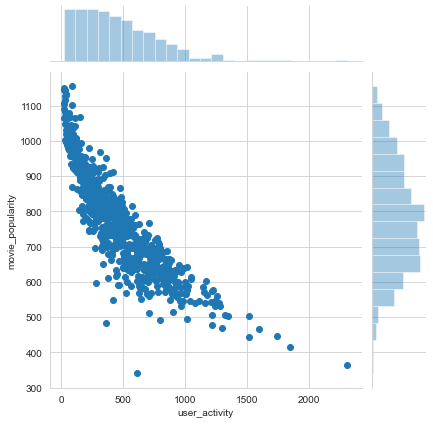

In [5]:
import seaborn as sns

# 用户活跃度
user_activity = movieLen_df[["user_id","movie_id"]].groupby("user_id").count()
user_activity.rename({"movie_id" : "user_activity"}, axis = 1, inplace = True)

# 物品活跃度
movie_popularity = (movieLen_df[["user_id","movie_id"]].groupby("movie_id", as_index = False).count())
movie_popularity.rename({"user_id" : "movie_popularity"}, axis = 1, inplace = True)


combine = pd.merge(left = movieLen_df, right = user_activity, on = "user_id")
combine = pd.merge(left = combine, right = movie_popularity, on = "movie_id")

combine = combine.groupby(["user_activity"],as_index = False).mean()

sns.set_style("whitegrid")
sns.jointplot(data = combine,x = "user_activity",y = "movie_popularity");

## 实验设计和算法评测

### 数据集
采用的是MoveLens数据集，包含6000多用户对4000多部电影的100万条评分。

In [6]:
movieLen_df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 实验设计


In [7]:
from sklearn.model_selection import KFold

def split_data(movieLen_df, M=8, seed=1):
    user_data = movieLen_df['user_id']
    movie_data = movieLen_df['movie_id']
    
    kf = KFold(M, True, seed)
    for train_index, test_index in kf.split(user_data):
        train_user_dataset = user_data.iloc[train_index]
        train_movie_dataset = movie_data.iloc[train_index]
        train_dataset = pd.DataFrame({'user_id': train_user_dataset, 'movie_id': train_movie_dataset})
        test_user_dataset = user_data.iloc[test_index]
        test_movie_dataset = movie_data.iloc[test_index]
        test_dataset = pd.DataFrame({'user_id': test_user_dataset, 'movie_id': test_movie_dataset})
        yield train_dataset, test_dataset

### 评测指标

对用户$u$推荐$N$个物品（记为$R(u)$），令用户$u$在测试集上喜欢的物品集合为$T(u)$，通过准确率/召回率评测推荐系统的精度：$$\text{Recall}=\frac{ \displaystyle \sum_u|R(u) \cap T(u)|}{\displaystyle \sum_u |T(u)|} \\ \text{Precision}=\frac{ \displaystyle \sum_u|R(u) \cap T(u)|}{\displaystyle \sum_u |R(u)|}$$召回率描述了有多少比例的用户-物品评分记录包含在最终的推荐列表中，而准确率描述最终的推荐列表中有多少比例是发生过的用户-物品评分记录。

In [8]:
def recall(recommends, tests):
    """
    计算Recall召回率
    :param recommends: 给用户推荐的商品，recommends为一个dict，格式为{ user_id : 推荐的物品 }
    :param tests: 测试集，同样为一个dict，格式为{ user_id : 实际发生行为的物品 }
    :return:
    """
    n_union = 0.
    recommend_sum = 0.
    for user_id, items in recommends.items():
        recommend_set = set(items)
        test_set = set(tests[user_id])
        n_union += len(recommend_set & test_set)
        recommend_sum += len(recommend_set)

    return n_union / recommend_sum

In [9]:
def precision(recommends, tests):
    """
    计算Precision
    :param recommends: 给用户推荐的商品，recommends为一个dict，格式为 { user_id : 推荐的物品 }
    :param tests: 测试集，同样为一个dict，格式为 { userID : 实际发生事务的物品 }
    :return: Precision
    """
    n_union = 0.
    user_sum = 0.
    for user_id, items in recommends.items():
        recommend_set = set(items)
        test_set = set(tests[user_id])
        n_union += len(recommend_set & test_set)
        user_sum += len(test_set)

    return n_union / user_sum

覆盖率反应了推荐算法发掘长尾的能力，覆盖率越高，说明推荐算法越能够将长尾中的物品推荐给用户。$$\text{Coverage}=\frac{|\bigcup_{u \in U}R(u)|}{|I|}$$如果所有的物品都被推荐给至少一个用户，那么覆盖率就是100%。

In [10]:
def coverage(recommends, all_items):
    """
    计算覆盖率
    :param recommends: 给用户推荐的商品，recommends为一个dict，格式为{ user_id : 推荐的物品 }
    :param all_items: 所有的物品，为list或set类型
    :return:
    """
    recommend_items = set()
    for _, items in recommends.items():
        for item in items:
            recommend_items.add(item)
    return len(recommend_items) / len(all_items)

用推荐列表中物品的平均流行度度量推荐结果的新颖度，如果推荐出的物品都很热门，说明推荐的新颖度较低，否则说明推荐结果比较新颖。

In [11]:
def popularity(item_popular, recommends):
    """
    计算流行度
    :param item_popular: 商品流行度　dict形式{ item_id : popularity}
    :param recommends: 给用户推荐的商品，recommends为一个dict，格式为{ user_id : 推荐的物品 }
    :return: 平均流行度
    """
    popularity_value = 0.  # 流行度
    n = 0.
    for _, items in recommends.items():
        for item in items:
            popularity_value += math.log(1. + item_popular.get(item, 0.))
            n += 1
    return popularity_value / n

## 基于领域的算法

### 基于用户的协同过滤算法

#### 基础算法
基于用户的协同过滤算法主要包括两个步骤：
1. 找到和目标用户兴趣相似的用户集合
2. 找到这个集合中的用户喜欢的，且目标用户没有听说过的物品推荐给目标用户

给定用户$u$和用户$v$，令$N(u)$表示用户$u$曾经有过正反馈的物品集合，令$N(v)$为用户$v$曾经有过正反馈的物品集合，通过余弦相似度计算$u$和$v$的兴趣相似度：$$w_{uv} = \frac{|N(u) \cap N(v)|}{\sqrt{|N(u)||N(v)|}}$$

In [2]:
from main.chapter2 import usercf
from main.util import movielen_reader

trainset,testset = movielen_reader.read_rating_data(path=PROJECT_ROOT + "/src/data/ml-1m/ratings.dat", train_rate = 0.8)

uf = usercf.UserCF(trainset)
sim_matrix_path = PROJECT_ROOT + "/src/main/chapter2/store/user_sim.pkl"
uf.train(sim_matrix_path)

开始训练模型
开始载入用户协同矩阵....
载入协同过滤矩阵完成
开始保存协同过滤矩阵
保存协同过滤矩阵完成


得到了用户之间的兴趣相似度后，UserCF算法就会给用户推荐和他兴趣最相似的K个用户喜欢的物品。  
UserCF算法中用户$u$对物品$i$的感兴趣程度：$$p(u,i)=\sum_{v \in S(u,K) \cap N(i)} w_{uv}r_{vi}$$其中，$S(u,K)$包含和用户$u$兴趣最接近的$K$个用户，$N(i)$是对物品$i$有过行为的用户集合，$w_{uv}$是用户$u$和用户$v$的兴趣相似度，$r_{vi}$表示用户$v$对物品$i$的兴趣。

In [3]:
test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)
    
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

from main.util import metric
from main.util import movielen_reader
import pandas as pd


def evaluate(N, K):
    """
    评估模型
    :param N: 推荐的商品个数
    :param K: 搜索邻近的用户个数
    :return: 精确率(precision), 召回率(recall), 覆盖率(coverage), 流行度(popularity)
    """
    recommens = uf.recommend_users(test.keys(), N=N, K=K)
    all_items = movielen_reader.all_items(PROJECT_ROOT + "/src/data/ml-1m/ratings.dat")
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends=recommens, tests=test)
    precision = metric.precision(recommends=recommens, tests=test)
    coverage = metric.coverage(recommends=recommens, all_items=all_items)
    popularity = metric.popularity(item_popular=item_popularity, recommends=recommens)

    return precision, recall, coverage, popularity

In [12]:
#表示推荐的商品个数
N = 30
#表示邻近用户的list
K_list = [5,10,20,40,80,160]  
usercf_evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    usercf_evals.append(single_eval)

In [13]:
pd.DataFrame(
        data = usercf_evals,
        index = K_list,
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
5,0.157383,0.173963,0.717485,6.558579
10,0.184202,0.203606,0.578251,6.724272
20,0.202993,0.224376,0.464652,6.845634
40,0.212825,0.235244,0.381274,6.945045
80,0.215473,0.238171,0.297895,7.033295
160,0.211316,0.233576,0.235834,7.119175


#### 用户相似度计算的改进

两个用户对冷门物品采取过同样的行为，更能说明他们兴趣的相似度，根据用户行为计算用户的兴趣相似度的改进公式：$$w_{uv}=\frac{\displaystyle \sum_{i \in N(u) \cap N(v)} \frac{1}{\log(1+|N(i)|)}}{\sqrt{|N(u)||N(v)|}}$$可以看到，该公式通过$\displaystyle \frac{1}{\log(1+|N(i)|)}$惩罚了用户$u$和用户$v$共同兴趣列表中热门物品对他们相似度的影响。

In [2]:
from main.chapter2 import useriif
from main.util import movielen_reader

trainset,testset = movielen_reader.read_rating_data(path=PROJECT_ROOT + "/src/data/ml-1m/ratings.dat", train_rate = 0.8)

user_iif = useriif.UserIIF(trainset)
sim_matrix_path = PROJECT_ROOT + "/src/main/chapter2/store/useriif_sim.pkl"
user_iif.train(sim_matrix_path)

开始训练模型
开始载入用户协同矩阵....
载入协同过滤矩阵完成
开始保存协同过滤矩阵
保存协同过滤矩阵完成


In [5]:
test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)
    
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

from main.util import metric
from main.util import movielen_reader
import pandas as pd


def evaluate(N, K):
    """
    评估模型
    :param N: 推荐的商品个数
    :param K: 搜索邻近的用户个数
    :return: 精确率(precision), 召回率(recall), 覆盖率(coverage), 流行度(popularity)
    """
    recommens = user_iif.recommend_users(test.keys(), N=N, K=K)
    all_items = movielen_reader.all_items(PROJECT_ROOT + "/src/data/ml-1m/ratings.dat")
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends=recommens, tests=test)
    precision = metric.precision(recommends=recommens, tests=test)
    coverage = metric.coverage(recommends=recommens, all_items=all_items)
    popularity = metric.popularity(item_popular=item_popularity, recommends=recommens)

    return precision, recall, coverage, popularity

In [8]:
N = 30   #表示推荐的商品个数
K_list = [80]  #表示临近用户的list
useriif_evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    useriif_evals.append(single_eval)

In [19]:
pd.DataFrame(
        data = [usercf_evals[5], useriif_evals[0]],
        index = ['UserCF', 'UserCF-IIF'],
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
UserCF,0.211316,0.233576,0.235834,7.119175
UserCF-IIF,0.216747,0.239579,0.317053,7.005780


### 基于物品的协同过滤算法

#### 基础算法

&emsp;&emsp;基于物品的协同过滤算法（简称ItemCF）给用户推荐那些和他们之前喜欢的物品相似的物品。ItemCF算法并不利用物品的内容属性计算物品之间的相似度，它主要通过分析用户的行为记录，计算物品之间的相似度。  
&emsp;&emsp;基于物品的协同过滤算法主要分为两步：
1. 计算物品之间的相似度
2. 根据物品的相似度和用户的历史行为，给用户生成推荐列表

物品的相似度公式：$$w_{ij}=\frac{|N(i) \cap N(j)|}{|N(i)|}$$其中$N(i)$是喜欢物品$i$的用户数，$|N(i) \cap N(j)|$是同时喜欢物品$i$和物品$j$的用户数。  
为了避免推荐出热门的物品，采用如下公式：$$w_{ij}=\frac{|N(i) \cap N(j)|}{\sqrt{|N(i)||N(j)|}}$$

In [2]:
from main.chapter2 import itemcf
from main.util import movielen_reader

trainset, testset = movielen_reader.read_rating_data(path=PROJECT_ROOT + "/src/data/ml-1m/ratings.dat", train_rate = 0.8)

item_cf = itemcf.ItemCF(trainset)
sim_matrix_path = PROJECT_ROOT + "/src/main/chapter2/store/item_sim.pkl"
item_cf.train(sim_matrix_path)

开始训练模型
开始载入用户协同矩阵....
载入协同过滤矩阵完成
开始保存协同过滤矩阵
保存协同过滤矩阵完成


得到物品之间的相似度后，ItemCF算法通过如下公式计算用户$u$对一个物品$j$的兴趣：$$p_{uj}=\sum_{i \in N(u) \cap S(j,k)}w_{ji}r_{ui}$$其中$N(u)$表示用户喜欢的物品集合，$S(j,k)$是和物品$j$最相似的$K$个物品的集合，$w_{ji}$是物品$j$和物品$i$的相似度，$r_{ui}$表示用户$u$和物品$i$的兴趣。（对于隐性反馈数据集，如果用户$u$对物品$i$有过行为，即可令$r_{ui}=1$）。  
公式含义：和用户历史上感兴趣的物品越相似的物品，越有可能在用户的推荐列表中获得比较高的排名。

In [3]:
from main.util import metric
from main.util import movielen_reader

test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)
    
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

def evaluate(N, K):
    """
    评估模型
    :param N: 推荐的商品个数
    :param K: 搜索邻近的用户个数
    :return: 精确率(precision), 召回率(recall), 覆盖率(coverage), 流行度(popularity)
    """
    recommens = item_cf.recommend_users(test.keys(), N=N, K=K)
    all_items = movielen_reader.all_items(PROJECT_ROOT + "/src/data/ml-1m/ratings.dat")
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends=recommens, tests=test)
    precision = metric.precision(recommends=recommens, tests=test)
    coverage = metric.coverage(recommends=recommens, all_items=all_items)
    popularity = metric.popularity(item_popular=item_popularity, recommends=recommens)

    return precision, recall, coverage, popularity

In [4]:
N = 30   #表示推荐的商品个数
K_list = [10]  #表示临近用户的list
item_evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    item_evals.append(single_eval)

In [5]:
pd.DataFrame(
        data = item_evals,
        index = K_list,
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
10,0.198071,0.218936,0.358877,6.994376


#### 物品相似度计算的改进

增加IUF（用户活跃度对数的倒数）参数，来修正物品相似度的计算公式：$$w_{ij}=\frac{\displaystyle \sum_{u \in N(i) \cap N(j)}\frac{1}{\log(1 + |N(u)|)}}{\sqrt{|N(i)||N(j)|}}$$

In [6]:
from main.util import movielen_reader
from main.chapter2 import itemiuf

trainset, testset = movielen_reader.read_rating_data(path=PROJECT_ROOT + "/src/data/ml-1m/ratings.dat", train_rate = 0.8)

item_iuf = itemiuf.ItemIUF(trainset)
sim_matrix_path = PROJECT_ROOT + "/src/main/chapter2/store/itemiuf_sim.pkl"
item_iuf.train(sim_matrix_path)

开始训练模型
开始载入用户协同矩阵....
载入协同过滤矩阵完成
开始保存协同过滤矩阵
保存协同过滤矩阵完成


In [7]:
from main.util import metric
from main.util import movielen_reader

test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)
    
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity


def evaluate(N, K):
    """
    评估模型
    :param N: 推荐的商品个数
    :param K: 搜索邻近的用户个数
    :return: 精确率(precision), 召回率(recall), 覆盖率(coverage), 流行度(popularity)
    """
    recommens = item_iuf.recommend_users(test.keys(), N=N, K=K)
    all_items = movielen_reader.all_items(PROJECT_ROOT + "/src/data/ml-1m/ratings.dat")
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends=recommens, tests=test)
    precision = metric.precision(recommends=recommens, tests=test)
    coverage = metric.coverage(recommends=recommens, all_items=all_items)
    popularity = metric.popularity(item_popular=item_popularity, recommends=recommens)

    return precision, recall, coverage, popularity

In [9]:
N = 30   #表示推荐的商品个数
K_list = [10]  #表示临近用户的list
itemiuf_evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    itemiuf_evals.append(single_eval)

In [10]:
pd.DataFrame(
        data = [item_evals[0], itemiuf_evals[0]],
        index = ['ItemCF', 'ItemCF-IUF'],
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
ItemCF,0.198071,0.218936,0.358877,6.994376
ItemCF-IUF,0.201664,0.222907,0.339450,7.066032


#### 物品相似度的归一化

如果将ItemCF的相似度矩阵按最大值归一化，可以提高推荐的准确率，如果已经得到了物品相似度矩阵$w$，那么可以用如下公式得到归一化之后的相似度矩阵$w'$：$$w'_{ij}=\frac{w_{ij}}{\displaystyle \max_j w_{ij}}$$归一化的好处不仅仅在于增加推荐的准确率，还可以提高推荐的覆盖率和多样性。

In [13]:
from main.util import movielen_reader
from main.chapter2 import itemnorm

trainset, testset = movielen_reader.read_rating_data(path=PROJECT_ROOT + "/src/data/ml-1m/ratings.dat", train_rate = 0.8)

item_norm = itemnorm.ItemNorm(trainset)
sim_matrix_path = PROJECT_ROOT + "/src/main/chapter2/store/itemnorm_sim.pkl"
item_norm.train(sim_matrix_path)

开始训练模型
开始载入用户协同矩阵....
载入协同过滤矩阵完成
开始保存协同过滤矩阵
保存协同过滤矩阵完成


In [14]:
test = dict()
for user,item,_ in testset:
    test.setdefault(user,list())
    test[user].append(item)
    
def train_popularity(train):
    """计算训练集的流行度"""
    train_popularity = dict()
    for user,item,_ in train:
        train_popularity.setdefault(item,0)
        train_popularity[item] += 1
    return train_popularity

def evaluate(N, K):
    """
    评估模型
    :param N: 推荐的商品个数
    :param K: 搜索邻近的用户个数
    :return: 精确率(precision), 召回率(recall), 覆盖率(coverage), 流行度(popularity)
    """
    recommens = item_norm.recommend_users(test.keys(), N=N, K=K)
    all_items = movielen_reader.all_items(PROJECT_ROOT + "/src/data/ml-1m/ratings.dat")
    item_popularity = train_popularity(trainset)

    recall = metric.recall(recommends=recommens, tests=test)
    precision = metric.precision(recommends=recommens, tests=test)
    coverage = metric.coverage(recommends=recommens, all_items=all_items)
    popularity = metric.popularity(item_popular=item_popularity, recommends=recommens)

    return precision, recall, coverage, popularity

In [15]:
N = 30   #表示推荐的商品个数
K_list = [10]  #表示临近用户的list
itemnorm_evals = list()

for k in K_list:
    single_eval = evaluate(N = N,K = k)
    itemnorm_evals.append(single_eval)

In [16]:
pd.DataFrame(
        data = [item_evals[0], itemnorm_evals[0]],
        index = ['ItemCF', 'ItemCF-Norm'],
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
ItemCF,0.198071,0.218936,0.358877,6.994376
ItemCF-Norm,0.198071,0.218936,0.359147,6.994348


### UserCF和ItemCF的综合比较

&emsp;&emsp;UserCF给用户推荐那些和他有共同兴趣爱好的用户喜欢的物品，而ItemCF给用户推荐那些和他之前喜欢的物品类似的物品。从这个算法原理可以看出，UserCF的推荐结果着重于反映和用户兴趣相似的小群体的热点，而ItemCF的推荐结果着重于维系用户的历史兴趣。  

| &emsp;&emsp;&emsp;&emsp; | <center>UserCF | <center>ItemCF 
| ---- | :--- | :--- 
| **性能** | 适用与用户较少的场合，如果用户很多，计算用户相似度矩阵代价很大 | 适用于物品数明显小于用户数的场合，如果物品很多（网页），计算物品相似度矩阵代价很大
| **领域** | 时效性较强，用户个性化兴趣不太明显的领域 | 长尾物品丰富，用户个性化需求强烈的领域
|**实时性** | 用户有新行为，不一定造成推荐结果的立即变化 | 用户有新行为，一定会导致推荐结果的实时变化
|**冷启动** | 在新用户对很少的物品产生行为后，不能立即对他进行个性化推荐，因为用户相似度表是每隔一段时间离线计算的。<br/><br/>新物品上线后一段时间，一旦有用户对物品产生行为，就可以将新物品推荐给和对它产生行为的用户兴趣相似的用户 | 新用户只要对一个物品产生行为，就可以给他推荐和该物品相关的其他物品<br/><br/>但没有办法在不离线更新物品相似度表的情况下将新物品推荐给用户
|**推荐理由** | 很难提供令用户信服的推荐解释 | 利用用户的历史行为给用户做推荐解释，可以令用户比较信服


## 隐语义模型

### 基础算法

&emsp;&emsp;LFM（latent factor model）隐语义模型的核心思想是通过隐含特征(latent factor)联系用户兴趣和物品。
LFM通过如下公式计算用户$u$对物品$i$的兴趣：$$\text{Preference}(u, i)=r_{ui}=p_u^T q_i = \sum_{k=1}^K p_{u,k} q_{i,k}$$其中$p_{u,k}$和$q_{i,k}$是模型的参数，$p_{u,k}$度量了用户$u$的兴趣和第$k$个隐类的关系，而$q_{i,k}$度量了第$k$个隐类和物品$i$的关系。  

在隐性反馈数据集上应用LFM解决TopN推荐的第一个关键问题就是如何给每个用户生成负样本。遵循的原则如下：
1. 对每个用户，要保证正负样本的平衡（数目相似）
2. 对每个用户采样负样本时，要选取那些很热门，而用户却没有行为的物品。

&emsp;&emsp;通过采样负样本得到那些热门的、但用户却没有过行为的物品，得到一个用户-物品集$K=\{(u, i)\}$，其中如果$(u, i)$是正样本，则有$r_{ui}=1$，否则有$r_{ui}=0$，之后优化损失函数求最合适的参数$p$和$q$：$$C=\sum_{(u,i) \in K} (r_{ui} - \hat{r}_{ui})^2 = \sum_{(u,i)\in K} \left( r_{ui} - \sum_{k=1}^K p_{u,k} q_{i,k} \right)^2 + \lambda \|p_u\|^2 + \lambda \|q_i\|^2$$采用梯度下降法，求偏导可得：$$\frac{\partial C}{\partial p_{uk}} = -2 q_{ik} \cdot e_{ui} + 2 \lambda p_{uk} \\ \frac{\partial C}{\partial q_{ik}} = -2p_{uk} \cdot e_{ui} + 2 \lambda q_{ik}$$参数需要沿着最速下降方向向前推进，可得：$$p'_{uk} = p_{uk} + \alpha (q_{ik} \cdot e_{ui} - \lambda p_{uk}) \\ q'_{ik} = q_{ik} + \alpha(p_{uk} \cdot e_{ui} - \lambda q_{ik})$$其中$\alpha$是学习速率(learning rate)。

### 基于LFM的实际系统的例子（雅虎）
&emsp;&emsp;LFM的每次训练都很耗时，一般在实际应用中只能每天训练一次，并且计算出所有用户的推荐系统，从而LFM模型不能因为用户行为的变化，实时地调整推荐结果来满足用户最近的行为。  
解决方案：
1. 利用新闻链接的内容属性（关键词、类别等）得到链接$i$的内容特征向量$y_i$。
2. 实时收集用户对链接的行为，并且用这些数据得到链接$i$的隐特征向量$q_i$。

通过如下公式预测用户$u$是否会点击链接$i$：$$r_{ui}=x_u^T \cdot y_i + p_u^T \cdot q_i$$其中，$y_i$是根据物品内容的属性直接生成的，$x_{uk}$是用户$u$对内容特征$k$的兴趣程度，用户向量$x_u$可以根据历史行为记录获得，而且每天只需要计算一次。$p_u$、$q_i$是根据实时拿到的用户最近几个小时的行为训练LFM获得的。

### LFM与基于邻域的方法比较

1. 理论基础  
LFM是一种学习方法，通过优化一个设定的指标建立最优的模型，基于邻域的方法是一种基于统计的方法，没有学习过程（即模型训练过程）
2. 离线计算的空间复杂度  
假设有M个用户和N个物品，基于邻域的方法需要维护一张离线的相关表，用户相关表需要的空间是$O(M*M)$，物品相关表需要的空间是$O(N*N)$，而LFM在建模过程中，如果有F个隐类，需要的空间是$O(F*(M+N))$
3. 离线计算的时间复杂度  
假设有M个用户、N个物品、K条用户对物品的行为记录。UserCF计算用户关系表的时间复杂度是$O(N*(K/N)^2)$，ItemCF算法计算物品相关表的时间复杂度是$O(M*(K/M)^2)$，对于LMF，如果有F个隐类，迭代S次（即epochs=S），计算复杂度是$O(K*F*S)$
4. 在线实时推荐  
UserCF和ItemCF在线服务算法需要将相关表缓存在内存中，可以在线进行实时预测。LFM在给用户生成推荐列表时，需要计算用户对所有物品的兴趣权重，然后排名，返回权重最大的N个物品，时间复杂度是$O(M*N*F)$，LFM不太适合用于物品数非常庞大的系统
5. 推荐解释  
ItemCF算法支持很好的推荐解释，利用用户的历史行为解释推荐结果，但LFM无法提供这样的解释

## 基于图的模型

### 基于图的推荐算法

将用户行为表示为二分图模型后，在该二分图上给用户进行个性化推荐。图中顶点的相关性主要取决于3个因素：
1. 两个顶点之间的路径数
2. 两个顶点之间的路径长度
3. 两个顶点之间的路径经过的顶点。

相关性高的一对顶点具有的特征：
1. 两个顶点之间有很多路径相连
2. 连接两个顶点之间的路径长度都比较短
3. 连接两个顶点之间的路径不会经过出度比较大的顶点

### PersionalRank算法

1. 从用户u对应的节点$v_u$开始在用户物品二分图上进行随机游走
2. 游走到任何一个节点时，按照概率$\alpha$是继续游走，还是停止本次游走并从$v_u$节点开始重新游走
3. 如果继续游走，那么就从当前节点指向的下一个节点按照均匀分布随机选择一个节点，作为游走的下一个节点
4. 经过很多次随机游走，每个物品节点被访问到的概率会收敛
5. 最终的推荐列表中，物品的权重就是物品节点的访问概率

概率公式：$$PR(v)=\left \{ \begin{array}{cc}
\displaystyle \alpha \sum_{v' \in in(v)} \frac{PR(v')}{|out(v')|} \quad (v \neq v_u) \\
\displaystyle (1-\alpha) + \alpha \sum_{v' \in in(v)} \frac{PR(v')}{|out(v')|} \quad (v = v_u)
\end{array} \right .$$

In [1]:
from operator import itemgetter

def PersonalRank(G, alpha, root, max_step):
    rank = {x: 0 for x in G.keys()}
    rank[root] = 1
    # 开始迭代
    for k in range(max_step):
        tmp = {x: 0 for x in G.keys()}
        # 取节点i和它的出边尾节点集合ri
        for i, ri in G.items():
            # 取节点i的出边的尾节点j以及边E(i,j)的权重wij, 边的权重都为1，归一化之后就上1/len(ri)
            for j, wij in ri.items():
                # i是j的其中一条入边的首节点，因此需要遍历图找到j的入边的首节点，
                # 这个遍历过程就是此处的2层for循环，一次遍历就是一次游走
                tmp[j] += alpha * rank[i] / (1.0 * len(ri))
        # 我们每次游走都是从root节点出发，因此root节点的权重需要加上(1 - alpha)
        tmp[root] += (1 - alpha)
        rank = tmp

    return sorted(rank.items(), key=itemgetter(1), reverse=True)

In [3]:
alpha = 0.8
G = {'A': {'a': 1, 'c': 1},
     'B': {'a': 1, 'b': 1, 'c': 1, 'd': 1},
     'C': {'c': 1, 'd': 1},
     'a': {'A': 1, 'B': 1},
     'b': {'B': 1},
     'c': {'A': 1, 'B': 1, 'C': 1},
     'd': {'B': 1, 'C': 1}}

rank = PersonalRank(G, alpha, 'A', 50)  # 从'b'节点开始游走

for ele in rank:
    print("%s:%.3f \t" % (ele[0], ele[1]))

A:0.314 	
c:0.189 	
B:0.166 	
a:0.159 	
C:0.076 	
d:0.063 	
b:0.033 	
